<a href="https://colab.research.google.com/github/jrebull/UX/blob/main/RedditVisaPreddictAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Instalación de Librerías

In [1]:
# Fundamentales para datos y análisis
!pip install pandas # Para la manipulación y análisis de datos en tablas (DataFrames).
!pip install matplotlib # Para crear visualizaciones y gráficos estáticos.
!pip install wordcloud # Para generar nubes de palabras a partir de texto.

# Para la obtención de datos de Reddit
!pip install praw # Biblioteca cliente para la API de Reddit, facilita la interacción.
!pip install asyncpraw # Versión asíncrona de PRAW para operaciones más eficientes.

# Para análisis de sentimientos
!pip install textblob # Para procesar datos textuales, análisis de sentimientos y más.
!pip install vaderSentiment # Especializada en análisis de sentimientos, muy útil para textos de redes sociales.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


# 2. Importación de Librerías

In [2]:
# --- Utilidades y Configuración del Entorno ---
from datetime import datetime          # Para trabajar con objetos de fecha y hora.
import logging                         # Para registrar eventos y depurar el código.
import warnings                        # Para gestionar y suprimir mensajes de advertencia.
from google.colab import userdata      # Específico de Colab, para acceder a secretos de forma segura.
import asyncio                         # Para gestionar operaciones asíncronas, necesario para asyncpraw.

# --- Adquisición de Datos (API de Reddit) ---
import praw                            # Cliente síncrono para la API de Reddit (operaciones secuenciales).
import asyncpraw                       # Cliente asíncrono para la API de Reddit (operaciones eficientes y concurrentes).

# --- Manipulación y Análisis de Datos ---
import pandas as pd                    # Para la manipulación y análisis de datos en tablas (DataFrames).

# --- Análisis de Texto y Sentimiento ---
from textblob import TextBlob          # Librería general para procesamiento de lenguaje natural y análisis de sentimiento.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Analizador de sentimiento optimizado para textos de redes sociales.

# --- Visualización de Datos ---
import matplotlib.pyplot as plt        # Para crear una amplia variedad de gráficos y visualizaciones estáticas.
from wordcloud import WordCloud        # Para generar nubes de palabras, una visualización de la frecuencia de términos.

In [3]:
# --- Configuración para Suprimir Advertencias (Warnings) ---

# Suprime la mayoría de las advertencias estándar de Python.
warnings.filterwarnings("ignore")

# Evita que las librerías PRAW y PRAWcore muestren advertencias a través del sistema de logging.
logging.getLogger('praw').setLevel(logging.ERROR)
logging.getLogger('prawcore').setLevel(logging.ERROR)

# Suprime el aviso específico que aparece al usar PRAW en un entorno asíncrono.
warnings.filterwarnings("ignore", message="It appears that you are using PRAW in an asynchronous environment.")

# 3. Configuración de Credenciales Reddit

In [4]:
# --- BLOQUE DE CONEXIÓN CON LA API DE REDDIT ---
try:
    # 1. Definir credenciales y User-Agent.
    # Se cargan las claves desde los 'Secrets' de Google Colab de forma segura.
    client_id = userdata.get('client_id_reddit')
    client_secret = userdata.get('client_secret_reddit')
    # El User-Agent identifica a tu script ante Reddit (es una práctica obligatoria).
    user_agent = 'Colab:VisaPredictAI:v1.0 by u/javirebull' # Reemplaza con tu usuario

    # 2. Validar que las credenciales no estén vacías.
    # Si alguna de las claves no se encuentra, se detiene el proceso con un error claro.
    if not client_id or not client_secret:
        raise ValueError("No se encontraron las credenciales en Secrets.")

    # 3. Inicializar la instancia de PRAW para conectar con Reddit.
    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent
    )

    # 4. Imprimir mensaje de éxito si todo ha ido bien.
    print("✅ Conexión exitosa a la API de Reddit.")

except Exception as e:
    # Capturar y mostrar cualquier error que ocurra durante la conexión.
    print(f"❌ Error al conectar: {e}")

✅ Conexión exitosa a la API de Reddit.


#  4: PARÁMETROS DE BÚSQUEDA Y EJECUCIÓN

In [5]:
# ==============================================================================
#  BLOQUE DE CONFIGURACIÓN COMPLETO PARA ANÁLISIS DE SENTIMIENTO
# ==============================================================================
# Objetivo: Analizar el sentimiento en Reddit sobre los procesos de inmigración
# y visas de EE. UU., con un enfoque en visas de trabajo y las herramientas
# que los solicitantes usan para seguir sus casos.

# --- 1. Subreddits a Monitorear (Versión Consolidada y Ampliada) ---
# Esta es la lista definitiva de comunidades a analizar.
subreddits = [
    # --- Comunidades Generales y de Proceso ---
    'immigration',        # Discusiones generales sobre inmigración a EE. UU.
    'USCIS',              # Sobre el Servicio de Ciudadanía e Inmigración (USCIS) y sus procesos.
    'USVisas',            # Comunidad amplia para todo tipo de visas de EE. UU.
    'greencard',          # Enfocado en el proceso de Residencia Permanente (Green Card).
    'MovingToUSA',        # Consejos prácticos y experiencias sobre mudarse a EE. UU.
    'IWantOut',           # Personas que planean emigrar desde su país de origen.
    'expat',              # Vida de expatriados, a menudo discuten procesos de visa y adaptación.

    # --- Visas de Trabajo y Empleo ---
    'h1b',                # Específico para la popular visa de trabajo H-1B.
    'tnvisa',             # Para la visa TN (profesionales de Canadá y México).
    'eb_1a',              # Para la visa de Habilidad Extraordinaria (EB-1A).
    'usajobs',            # Trabajos federales, a menudo con requisitos de ciudadanía o visa.

    # --- Comunidades Específicas y de Nicho ---
    'I130Suffering',      # Comunidad de apoyo y desahogo para el lento proceso de la petición familiar I-130.
    'DACA',               # Para beneficiarios del programa DACA.
    'GreenCardInsights',  # Análisis de datos y tendencias del proceso de Green Card.
    'phmigrate',          # Específico para la inmigración desde Filipinas.
    'EyesOnIce'           # Discusiones y noticias sobre el Servicio de Inmigración y Control de Aduanas (ICE).
]

# --- 2. Palabras Clave para Filtrar Posts ---
# Las palabras se agrupan por tema para enfocar la búsqueda de manera precisa.
keywords = [
    # Términos Generales y de Visas de Trabajo
    'VISA', 'WORK VISA', 'visa process', 'immigration visa', 'visa delay',
    'H1B', 'TN', 'L1 visa', 'O1 visa', 'E2 visa', 'work permit',
    'employer sponsorship',

    # Términos del Proceso de Green Card (GC)
    'GC', 'green card', 'PERM', 'labor certification', 'I-485', 'I-140',
    'priority date',

    # Términos sobre Herramientas y Seguimiento de Casos (Apps)
    'Lawfully', 'Case Tracker', 'Hilites', 'case status', 'myUSCIS',
    'online tracker', 'USCIS app', 'visa tracking', 'status checker',

    # Términos relacionados con el estado y sentimiento del proceso
    'approval', 'denial', 'approved', 'denied', 'RFE', 'Request for Evidence',
    'processing times', 'interview experience', 'frustration', 'stuck'
]

# --- 3. Límite de Posts a Extraer ---
# Define el número máximo de posts a obtener por cada combinación de subreddit/keyword.
post_limit = 1000

# --- 4. Confirmación de Parámetros ---
# Imprime un resumen de la configuración para verificar que todo está correcto antes de ejecutar.
print("✅ Configuración de Búsqueda Completa y Lista para Ejecutar.")
print("==========================================================")
print(f"   - Límite por búsqueda: {post_limit} posts")
print(f"   - Total de Subreddits: {len(subreddits)}")
print(f"   - Total de Palabras Clave: {len(keywords)}")

✅ Configuración de Búsqueda Completa y Lista para Ejecutar.
   - Límite por búsqueda: 1000 posts
   - Total de Subreddits: 16
   - Total de Palabras Clave: 38


# 5. Fetch de Datos de Reddit

In [6]:
# ==============================================================================
#  PASO 5: RECOLECCIÓN, ANÁLISIS Y CREACIÓN DEL DATAFRAME (VERSIÓN MEJORADA)
# ==============================================================================

# --- Funciones de Ayuda para un Código Más Limpio ---

def get_sentiment_scores(text, analyzer):
    """
    Analiza un texto y devuelve su puntaje de sentimiento y una etiqueta.
    Devuelve (0.0, 'neutral') si el texto está vacío.
    """
    if not text:
        return 0.0, 'neutral'

    # Calcula el puntaje de sentimiento compuesto (-1 a 1)
    score = analyzer.polarity_scores(text)['compound']

    # Asigna una etiqueta basada en el puntaje
    if score > 0.05:
        label = 'positivo'
    elif score < -0.05:
        label = 'negativo'
    else:
        label = 'neutral'

    return score, label

# --- Inicio del Proceso de Recolección ---

# 1. Inicializar componentes
data = []  # Lista para almacenar todos los registros (posts y comentarios)
analyzer = SentimentIntensityAnalyzer() # Instancia del analizador de VADER
search_query = ' OR '.join(keywords)   # Construye la consulta de búsqueda una sola vez

print(f"\n🚀 Iniciando recolección de hasta {post_limit} posts por subreddit...")
print(f"Buscando posts con las palabras clave: '{search_query[:75]}...'")

# 2. Bucle principal para recorrer subreddits y posts
for sub_name in subreddits:
    print(f"\n🔍 Procesando subreddit: r/{sub_name}")
    try:
        subreddit = reddit.subreddit(sub_name)

        # Busca los posts más recientes que coincidan con las palabras clave
        for post in subreddit.search(search_query, sort='new', limit=post_limit):

            # --- Procesar el Post Principal ---
            title_score, _ = get_sentiment_scores(post.title, analyzer)
            text_score, _ = get_sentiment_scores(post.selftext, analyzer)

            # Calcula el sentimiento promedio entre título y texto (si existe)
            post_sentiment_score = (title_score + text_score) / 2 if post.selftext else title_score
            _, post_sentiment_label = get_sentiment_scores(f"{post.title} {post.selftext}", analyzer)

            data.append({
                'type': 'Post',
                'subreddit': sub_name,
                'title': post.title,
                'text': post.selftext,
                'score': post.score,
                'num_comments': post.num_comments,
                'created': datetime.fromtimestamp(post.created_utc),
                'sentiment_score': post_sentiment_score,
                'sentiment_label': post_sentiment_label
            })

            # --- Procesar los Comentarios del Post ---
            post.comments.replace_more(limit=0) # Carga solo los comentarios de nivel superior
            # Itera sobre los primeros 10 comentarios para no sobrecargar el análisis
            for comment in post.comments.list()[:10]:
                comment_score, comment_label = get_sentiment_scores(comment.body, analyzer)

                data.append({
                    'type': 'Comment',
                    'subreddit': sub_name,
                    'title': f"Comment on: {post.title[:50]}...", # Título para referencia
                    'text': comment.body,
                    'score': comment.score,
                    'num_comments': 0, # Los comentarios no tienen sub-comentarios en este contexto
                    'created': datetime.fromtimestamp(comment.created_utc),
                    'sentiment_score': comment_score,
                    'sentiment_label': comment_label
                })

    except Exception as e:
        print(f"  -> ❗️ Error procesando r/{sub_name}. Saltando al siguiente. Error: {e}")

# --- 3. Creación y Visualización del DataFrame ---
if data:
    df = pd.DataFrame(data)
    print(f"\n✅ Análisis completado. Se recolectaron {len(df):,} entradas (posts y comentarios).")

    # Muestra las primeras filas del DataFrame
    print("\n--- Primeras 10 Entradas Recolectadas ---")
    display(df.head(10))

    # Muestra un resumen del sentimiento general
    print("\n--- Resumen de Sentimientos ---")
    display(df['sentiment_label'].value_counts(normalize=True).map('{:.2%}'.format))

else:
    print("\n⚠️ No se recolectaron datos. Revisa tus palabras clave, subreddits o la conexión a la API.")


🚀 Iniciando recolección de hasta 1000 posts por subreddit...
Buscando posts con las palabras clave: 'VISA OR WORK VISA OR visa process OR immigration visa OR visa delay OR H1B ...'

🔍 Procesando subreddit: r/immigration

🔍 Procesando subreddit: r/USCIS

🔍 Procesando subreddit: r/USVisas

🔍 Procesando subreddit: r/greencard

🔍 Procesando subreddit: r/MovingToUSA

🔍 Procesando subreddit: r/IWantOut

🔍 Procesando subreddit: r/expat

🔍 Procesando subreddit: r/h1b

🔍 Procesando subreddit: r/tnvisa

🔍 Procesando subreddit: r/eb_1a

🔍 Procesando subreddit: r/usajobs
  -> ❗️ Error procesando r/usajobs. Saltando al siguiente. Error: received 429 HTTP response

🔍 Procesando subreddit: r/I130Suffering
  -> ❗️ Error procesando r/I130Suffering. Saltando al siguiente. Error: received 429 HTTP response

🔍 Procesando subreddit: r/DACA
  -> ❗️ Error procesando r/DACA. Saltando al siguiente. Error: received 429 HTTP response

🔍 Procesando subreddit: r/GreenCardInsights
  -> ❗️ Error procesando r/GreenC

,type,subreddit,title,text,score,num_comments,created,sentiment_score,sentiment_label
0,Post,immigration,"N400 Interview @ San Francisco, CA","hey everyone, i’m not sure if i can post this ...",2,0,2025-08-01 03:51:17,0.36840,positivo
1,Post,immigration,Travel to Germany,انا عندي ١٨ سنه متاخر سنه ولسا هبدا تالته ثانو...,1,0,2025-08-01 03:36:21,0.20430,positivo
2,Post,immigration,K1 administrative processing for a year now,"Hello, so my finance went to her interview and...",1,0,2025-08-01 03:04:22,0.18865,positivo
3,Post,immigration,Need help navigating through immigration,I am attempting to keep this a vague as possib...,0,32,2025-08-01 02:34:46,-0.27475,negativo
4,Comment,immigration,Comment on: Need help navigating through immig...,"Given you're over 21, your path is basically m...",6,0,2025-08-01 02:45:44,0.00000,neutral
5,Comment,immigration,Comment on: Need help navigating through immig...,"Did you enter legally? If yes, your easiest pa...",2,0,2025-08-01 02:37:55,0.60960,positivo
6,Comment,immigration,Comment on: Need help navigating through immig...,Where are you from? Did u come thru a visa ?,1,0,2025-08-01 02:42:43,0.00000,neutral
7,Comment,immigration,Comment on: Need help navigating through immig...,What is your current status ?,1,0,2025-08-01 02:47:57,0.00000,neutral
8,Comment,immigration,Comment on: Need help navigating through immig...,"Even if you got married to a us citizen, it ta...",1,0,2025-08-01 03:41:37,-0.76500,negativo
9,Comment,immigration,Comment on: Need help navigating through immig...,Not even if he's adopted by a U.S. citizen ste...,1,0,2025-08-01 02:44:38,0.00000,neutral



--- Resumen de Sentimientos ---


,proportion
sentiment_label,
positivo,57.22%
neutral,22.08%
negativo,20.70%


In [7]:
# 1. Guardar como CSV
df.to_csv('resultados.csv', index=False, encoding='utf-8-sig')

# 2. Guardar con pickle (serialización de pandas)
df.to_pickle('resultados.pkl')


In [8]:
# Carga desde CSV
df = pd.read_csv('resultados.csv', encoding='utf-8-sig')

# ——— Ver los primeros 10 registros (top 10) ———
print("=== Primeras 10 filas ===")
print(df.head(10))

# ——— Ver los últimos 10 registros (bottom 10) ———
print("\n=== Últimas 10 filas ===")
print(df.tail(10))

# ——— Total de registros ———
total = len(df)
print(f"\nTotal de registros: {total:,}")


=== Primeras 10 filas ===
      type    subreddit                                              title  \
0     Post  immigration                 N400 Interview @ San Francisco, CA   
1     Post  immigration                                  Travel to Germany   
2     Post  immigration        K1 administrative processing for a year now   
3     Post  immigration           Need help navigating through immigration   
4  Comment  immigration  Comment on: Need help navigating through immig...   
5  Comment  immigration  Comment on: Need help navigating through immig...   
6  Comment  immigration  Comment on: Need help navigating through immig...   
7  Comment  immigration  Comment on: Need help navigating through immig...   
8  Comment  immigration  Comment on: Need help navigating through immig...   
9  Comment  immigration  Comment on: Need help navigating through immig...   

                                                text  score  num_comments  \
0  hey everyone, i’m not sure if i can

In [9]:
from google.colab import drive
# 1. Montar Drive
drive.mount('/content/drive')

# 2. Guardar el CSV y el pickle en tu Drive
df.to_csv('/content/drive/My Drive/resultados.csv', index=False, encoding='utf-8-sig')
df.to_pickle('/content/drive/My Drive/resultados.pkl')

print("✅ Archivos guardados en Google Drive")


Mounted at /content/drive
✅ Archivos guardados en Google Drive


In [10]:
from google.colab import drive
import pandas as pd

# 1. Montar tu Google Drive
drive.mount('/content/drive')

# 2. Rutas a tus archivos en Drive (ajusta si están en otra carpeta)
csv_path = '/content/drive/My Drive/resultados.csv'
pkl_path = '/content/drive/My Drive/resultados.pkl'

# 3. Cargar desde CSV
df_csv = pd.read_csv(csv_path, encoding='utf-8-sig')

print("=== CSV: Primeras 10 filas ===")
print(df_csv.head(10))

print("\n=== CSV: Últimas 10 filas ===")
print(df_csv.tail(10))

print(f"\nCSV – Total de registros: {len(df_csv):,}")

# 4. Cargar desde Pickle
df_pkl = pd.read_pickle(pkl_path)

print("\n=== Pickle: Primeras 10 filas ===")
print(df_pkl.head(10))

print("\n=== Pickle: Últimas 10 filas ===")
print(df_pkl.tail(10))

print(f"\nPickle – Total de registros: {len(df_pkl):,}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== CSV: Primeras 10 filas ===
      type    subreddit                                              title  \
0     Post  immigration                 N400 Interview @ San Francisco, CA   
1     Post  immigration                                  Travel to Germany   
2     Post  immigration        K1 administrative processing for a year now   
3     Post  immigration           Need help navigating through immigration   
4  Comment  immigration  Comment on: Need help navigating through immig...   
5  Comment  immigration  Comment on: Need help navigating through immig...   
6  Comment  immigration  Comment on: Need help navigating through immig...   
7  Comment  immigration  Comment on: Need help navigating through immig...   
8  Comment  immigration  Comment on: Need help navigating through immig...   
9  Comment  immigration  Comment on: Need help navigating th

sentiment_label
positivo    59.810726
negativo    22.208202
neutral     17.981073
Name: proportion, dtype: float64


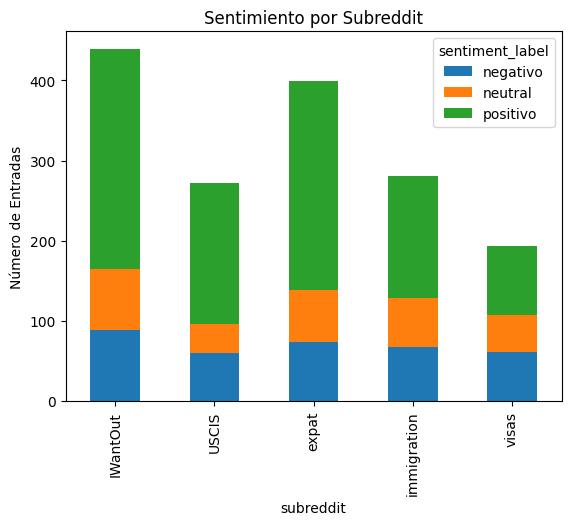

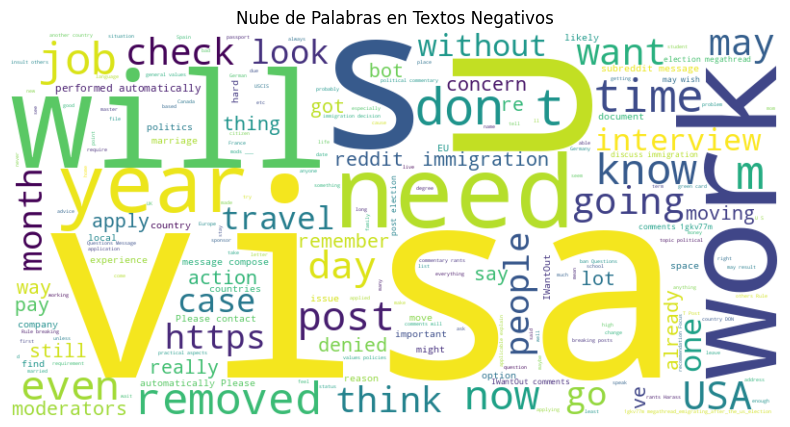

Datos exportados a CSV.


In [10]:
# Estadísticas básicas
print(df['sentiment_label'].value_counts(normalize=True) * 100)  # Porcentajes de sentimientos

# Gráfico de barras por subreddit
df.groupby(['subreddit', 'sentiment_label']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Sentimiento por Subreddit')
plt.ylabel('Número de Entradas')
plt.show()

# Nube de palabras para textos negativos (ejemplo)
negative_text = ' '.join(df[df['sentiment_label'] == 'negativo']['text'].dropna())
if negative_text:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras en Textos Negativos')
    plt.show()
else:
    print("No hay textos negativos para generar nube.")

# Opcional: Exporta a CSV
df.to_csv('analisis_sentimiento_reddit.csv', index=False)
print("Datos exportados a CSV.")

In [11]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# Ejemplo: df['text_clean'] = df['text'].apply(lambda x: ' '.join(word_tokenize(x.lower())))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
